In [3]:
import math
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [8]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2857],
         [-1.3213]]),
 tensor([[ 1.0000e+00, -2.8569e-01,  4.0810e-02, -3.8864e-03,  2.7758e-04,
          -1.5861e-05,  7.5522e-07, -3.0823e-08,  1.1007e-09, -3.4942e-11,
           9.9826e-13, -2.5927e-14,  6.1726e-16, -1.3565e-17,  2.7682e-19,
          -5.2724e-21,  9.4144e-23, -1.5821e-24,  2.5111e-26, -3.7759e-28],
         [ 1.0000e+00, -1.3213e+00,  8.7288e-01, -3.8444e-01,  1.2699e-01,
          -3.3557e-02,  7.3897e-03, -1.3948e-03,  2.3037e-04, -3.3820e-05,
           4.4686e-06, -5.3674e-07,  5.9099e-08, -6.0066e-09,  5.6688e-10,
          -4.9934e-11,  4.1235e-12, -3.2049e-13,  2.3525e-14, -1.6360e-15]]),
 tensor([ 4.5357, -1.6143]))

In [12]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.995904   1.2047046 -3.3909998  5.571621 ]]


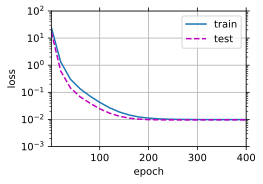

In [13]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])